In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import torch
from keras.datasets import mnist

In [4]:
###
### Regular MNIST
###

In [5]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

In [6]:
print(train_x.shape)
print(train_x.flatten())
print(test_x.shape)

data = []
train_data = train_x.tolist()
test_data = test_x.tolist()
for value in train_data:
    data.append(value)
for item in test_data:
    data.append(item)
data = np.array(data)

#Standardize data
inputs = train_x - np.mean(data)
inputs = inputs/(np.std(data))

#standardize test data
test_inputs = test_x - np.mean(data)
test_inputs = test_inputs/(np.std(data))

targets = train_y
test_targets = test_y

(60000, 28, 28)
[0 0 0 ... 0 0 0]
(10000, 28, 28)


In [7]:
#One-hot encoding
def create_target(t):
        target_vector = np.zeros(10)
        for i in range(10):
            if i == t:
                target_vector[i] = 1
        return target_vector

#Hard sigmoid [-1, 1]
def hsig(x):
    z = np.clip(x, -1, 1)
    return np.copy(z)

def d_hsig(x):
    z = (x > -1) & (x < 1)
    return np.copy(z)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [8]:
#Define network hyperparameters
n_x = 784
n_h = 500
n_y = 10

alpha1 = 0.01
alpha2 = 0.005
beta = 1
epsilon = 0.1

epochs = 12000

x_plot = []
h_plot = []
y_plot = []
w1_plot = []
w2_plot = []
energy_plot = []
first_term_plot = []
second_term_plot = []
third_term_plot = []

#Weight intialization
W1 = np.random.uniform(0, (4/(n_x + n_y)), (n_x, n_h))
W2 = np.random.uniform(0, (4/(n_h)), (n_h, n_y))

#Bias initialization
bh = np.random.uniform(0, 4/(n_x + n_y), n_h)
by = np.random.uniform(0, 4/(n_h), n_y)

for ex in range(epochs*100):
    
    #Randomly sample from data
    #rnd = np.random.randint(0, 60000)
    index = ex % len(inputs)
    x = inputs[index].flatten()
    t = create_target(targets[index])
    #x = inputs[rnd].flatten()# + 0.1 * np.random.rand(64)
    #t = create_target(targets[rnd])
    
    #Random activation initialization
    h = np.random.uniform(-1, 1, n_h)
    y = np.random.uniform(-1, 1, n_y)
    
    #Free Phase
    for itr in range(100):
        #Calculate free gradient steps
        dh = d_hsig(h) * (np.dot(x, W1) + np.dot(y, W2.T) + bh) - h
        dy = d_hsig(y) * (np.dot(h, W2) + by) - y
        
        #Update activations
        h = hsig(h + epsilon * dh)
        y = hsig(y + epsilon * dy)
        
    #Store free equilibrium states
    h_free = np.copy(h)
    y_free = np.copy(y)
    
    #Weakly Clamped Phase
    for itr in range(50):
        #Calculate weakly clamped gradient steps
        dy = d_hsig(y) * (np.dot(h, W2) + by) - y + beta * (t - y)
        dh = d_hsig(h) * (np.dot(x, W1) + np.dot(y, W2.T) + bh) - h
        
        #Update activations
        h = hsig(h + epsilon * dh)
        y = hsig(y + epsilon * dy)
        
    #Store weakly clamped activations
    h_clamped = np.copy(h)
    y_clamped = np.copy(y)
    
    x_plot.append(np.mean(x))
    h_plot.append(np.mean(h))
    y_plot.append(np.mean(y))
    
    #Update weights
    W1 += alpha1 * (1/beta) * (np.outer(x, h_clamped) - np.outer(x, h_free))
    W2 += alpha2 * (1/beta) * (np.outer(h_clamped, y_clamped) - np.outer(h_free, y_free))
    
    w1_plot.append(np.sum(W1))
    w2_plot.append(np.sum(W2))
    
    #Print Mean Squared Error
    if ex % 100 == 0:
        
        mse = np.dot(t - y_free, t - y_free)
        
        print('epoch '+str((ex//100)+1)+' of '+str(epochs)+' -- ex: '+str(index)+' -- mse: '+str(mse), end = "\r")
        
        energy = epsilon * 0.5 * (np.sum(x**2) + np.sum(h**2) + np.sum(y**2))
        
        w1_mat = W1 * np.outer(hsig(x),hsig(h))
        np.fill_diagonal(w1_mat,0)
        energy -= 0.5 * np.sum(w1_mat)
        
        w2_mat = W2 * np.outer(hsig(h),hsig(y))
        np.fill_diagonal(w2_mat,0)
        energy -= 0.5 * np.sum(w2_mat)

        energy -= 0.5 * np.sum(bh * hsig(h))
        energy -= 0.5 * np.sum(by * hsig(y))
        energy += np.sum((t - y_free)**2)
        energy_plot.append(energy)
        
    #Learning rate schedule
    if ex % 60000 == 59999:
        alpha1 /= 10
        alpha2 /= 10

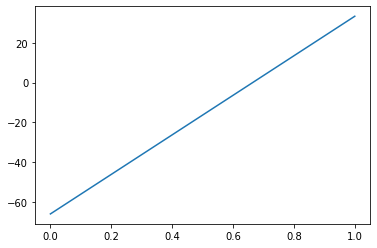

In [6]:
plt.plot(energy_plot)
plt.show()

In [9]:
#Test Accuracy

###
### Gets 91.31% on MNIST after 3 epochs
###
### 90.59% after 2 epochs
###
### Running for 20 epochs...
### GOt 90.99% after 20 epochs
###

score = 0
samples = 10000
for test in range(samples):
    rnd = test
    x = test_inputs[rnd].flatten()
    t = create_target(test_targets[rnd])
    h = np.random.uniform(-1, 1, n_h)
    y = np.random.uniform(-1, 1, n_y)
    
    #Free Phase
    for itr in range(100):
        dh = d_hsig(h) * (np.dot(x, W1) + np.dot(y, W2.T) + bh) - h
        dy = d_hsig(y) * (np.dot(h, W2) + by) - y
        
        h = hsig(h + epsilon * dh)
        y = hsig(y + epsilon * dy)
        
    h_free = np.copy(h)
    y_free = np.copy(y)
    
    if np.argmax(y_free) == test_targets[rnd]:
        score += 1
    
    print('tested sample ' + str(test+1) + ' of '+str(samples), end = "\r")

print('\n')
print(score/samples)

tested sample 10000 of 10000

0.9099


In [45]:
###
### Initialized Regular MNIST
###

In [46]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

In [47]:
print(train_x.shape)
print(train_x.flatten())
print(test_x.shape)

data = []
train_data = train_x.tolist()
test_data = test_x.tolist()
for value in train_data:
    data.append(value)
for item in test_data:
    data.append(item)
data = np.array(data)

#Standardize data
inputs = train_x - np.mean(data)
inputs = inputs/(np.std(data))

#standardize test data
test_inputs = test_x - np.mean(data)
test_inputs = test_inputs/(np.std(data))

targets = train_y
test_targets = test_y

(60000, 28, 28)
[0 0 0 ... 0 0 0]
(10000, 28, 28)


In [48]:
#One-hot encoding
def create_target(t):
        target_vector = np.zeros(10)
        for i in range(10):
            if i == t:
                target_vector[i] = 1
        return target_vector

#Hard sigmoid [-1, 1]
def hsig(x):
    z = np.clip(x, -1, 1)
    return np.copy(z)

def d_hsig(x):
    z = (x > -1) & (x < 1)
    return np.copy(z)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [49]:
#Define network hyperparameters
n_x = 784
n_h = 500
n_y = 10

alpha1 = 0.01
alpha2 = 0.005
beta = 1
epsilon = 0.1
#epsilon = 0.01

epochs = .01

x_plot = []
h_plot = []
y_plot = []
w1_plot = []
w2_plot = []
energy_plot = []
first_term_plot = []
second_term_plot = []
third_term_plot = []

#Weight intialization
#W1 = np.random.uniform(0, (4/(n_x + n_y)), (n_x, n_h))
#W2 = np.random.uniform(0, (4/(n_h)), (n_h, n_y))

#Bias initialization
#bh = np.random.uniform(0, 4/(n_x + n_y), n_h)
#by = np.random.uniform(0, 4/(n_h), n_y)

W1 = np.load('reg_w1.npy')
W2 = np.load('reg_w2.npy')
bh = np.load('reg_bh.npy')
by = np.load('reg_by.npy')

for ex in range(int(epochs*100)):
    
    #Randomly sample from data
    #rnd = np.random.randint(0, 60000)
    index = ex % len(inputs)
    x = inputs[index].flatten()
    t = create_target(targets[index])
    #x = inputs[rnd].flatten()# + 0.1 * np.random.rand(64)
    #t = create_target(targets[rnd])
    
    #Random activation initialization
    h = np.random.uniform(-1, 1, n_h)
    y = np.random.uniform(-1, 1, n_y)
    
    #Free Phase
    for itr in range(100):
        #Calculate free gradient steps
        dh = d_hsig(h) * (np.dot(x, W1) + np.dot(y, W2.T) + bh) - h
        dy = d_hsig(y) * (np.dot(h, W2) + by) - y
        
        #Update activations
        h = hsig(h + epsilon * dh)
        y = hsig(y + epsilon * dy)
        
    #Store free equilibrium states
    h_free = np.copy(h)
    y_free = np.copy(y)
    
    #Weakly Clamped Phase
    for itr in range(50):
        #Calculate weakly clamped gradient steps
        dy = d_hsig(y) * (np.dot(h, W2) + by) - y + beta * (t - y)
        dh = d_hsig(h) * (np.dot(x, W1) + np.dot(y, W2.T) + bh) - h
        
        #Update activations
        h = hsig(h + epsilon * dh)
        y = hsig(y + epsilon * dy)
        
    #Store weakly clamped activations
    h_clamped = np.copy(h)
    y_clamped = np.copy(y)
    
    x_plot.append(np.mean(x))
    h_plot.append(np.mean(h))
    y_plot.append(np.mean(y))
    
    #Update weights
    W1 += alpha1 * (1/beta) * (np.outer(x, h_clamped) - np.outer(x, h_free))
    W2 += alpha2 * (1/beta) * (np.outer(h_clamped, y_clamped) - np.outer(h_free, y_free))
    
    w1_plot.append(np.sum(W1))
    w2_plot.append(np.sum(W2))
    
    #Print Mean Squared Error
    if ex % 100 == 0:
        
        mse = np.dot(t - y_free, t - y_free)
        
        print('epoch '+str((ex//100)+1)+' of '+str(epochs)+' -- ex: '+str(index)+' -- mse: '+str(mse), end = "\r")
        
        energy = epsilon * 0.5 * (np.sum(x**2) + np.sum(h**2) + np.sum(y**2))
        
        w1_mat = W1 * np.outer(hsig(x),hsig(h))
        np.fill_diagonal(w1_mat,0)
        energy -= 0.5 * np.sum(w1_mat)
        
        w2_mat = W2 * np.outer(hsig(h),hsig(y))
        np.fill_diagonal(w2_mat,0)
        energy -= 0.5 * np.sum(w2_mat)

        energy -= 0.5 * np.sum(bh * hsig(h))
        energy -= 0.5 * np.sum(by * hsig(y))
        energy += np.sum((t - y_free)**2)
        energy_plot.append(energy)
        
    #Learning rate schedule
    if ex % 60000 == 59999:
        alpha1 /= 10
        alpha2 /= 10

In [51]:
#Test Accuracy
score = 0
samples = 10000
for test in range(samples):
    energy_plot = []
    rnd = test
    x = test_inputs[rnd].flatten()
    t = create_target(test_targets[rnd])
    h = np.random.uniform(-1, 1, n_h)
    y = np.random.uniform(-1, 1, n_y)
    
    #Free Phase
    for itr in range(100):
        dh = d_hsig(h) * (np.dot(x, W1) + np.dot(y, W2.T) + bh) - h
        dy = d_hsig(y) * (np.dot(h, W2) + by) - y
        
        h = hsig(h + epsilon * dh)
        y = hsig(y + epsilon * dy)
        
        energy = 0.5 * (np.sum(x**2) + np.sum(h**2) + np.sum(y**2))
        
        w1_mat = W1 * np.outer(hsig(x),hsig(h))
        np.fill_diagonal(w1_mat,0)
        energy -= 0.5 * np.sum(w1_mat)
        
        w2_mat = W2 * np.outer(hsig(h),hsig(y))
        np.fill_diagonal(w2_mat,0)
        energy -= 0.5 * np.sum(w2_mat)

        energy -= 0.5 * np.sum(bh * hsig(h))
        energy -= 0.5 * np.sum(by * hsig(y))
        energy += np.sum((t - y_free)**2)
        energy_plot.append(energy)
        
    h_free = np.copy(h)
    y_free = np.copy(y)
    
    if np.argmax(y_free) == test_targets[rnd]:
        score += 1
    
    print('tested sample ' + str(test+1) + ' of '+str(samples), end = "\r")

print('\n')
print(score/samples)

tested sample 10000 of 10000

0.9574


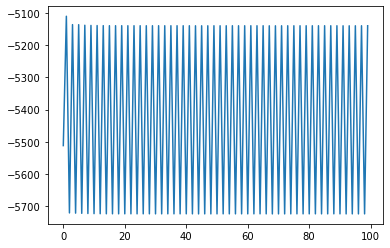

In [52]:
plt.plot(energy_plot)
plt.show()

In [8]:
###
### Energy plot after normal training
###

In [13]:
#Define network hyperparameters
n_x = 784
n_h = 500
n_y = 10

alpha1 = 0.01
alpha2 = 0.005
beta = 1
#epsilon = 0.1
epsilon = 0.01

epochs = 10

x_plot = []
h_plot = []
y_plot = []
w1_plot = []
w2_plot = []
energy_plot = []
first_term_plot = []
second_term_plot = []
third_term_plot = []

#Weight intialization
W1 = np.random.uniform(0, (4/(n_x + n_y)), (n_x, n_h))
W2 = np.random.uniform(0, (4/(n_h)), (n_h, n_y))

#Bias initialization
bh = np.random.uniform(0, 4/(n_x + n_y), n_h)
by = np.random.uniform(0, 4/(n_h), n_y)

#W1 = np.load('reg_w1.npy')
#W2 = np.load('reg_w2.npy')
#bh = np.load('reg_bh.npy')
#by = np.load('reg_by.npy')

for ex in range(int(epochs*100)):
    
    #Randomly sample from data
    #rnd = np.random.randint(0, 60000)
    index = ex % len(inputs)
    x = inputs[index].flatten()
    t = create_target(targets[index])
    #x = inputs[rnd].flatten()# + 0.1 * np.random.rand(64)
    #t = create_target(targets[rnd])
    
    #Random activation initialization
    h = np.random.uniform(-1, 1, n_h)
    y = np.random.uniform(-1, 1, n_y)
    
    #Free Phase
    for itr in range(1000):
        #Calculate free gradient steps
        dh = d_hsig(h) * (np.dot(x, W1) + np.dot(y, W2.T) + bh) - h
        dy = d_hsig(y) * (np.dot(h, W2) + by) - y
        
        #Update activations
        h = hsig(h + epsilon * dh)
        y = hsig(y + epsilon * dy)
        
    #Store free equilibrium states
    h_free = np.copy(h)
    y_free = np.copy(y)
    
    #Weakly Clamped Phase
    for itr in range(500):
        #Calculate weakly clamped gradient steps
        dy = d_hsig(y) * (np.dot(h, W2) + by) - y + beta * (t - y)
        dh = d_hsig(h) * (np.dot(x, W1) + np.dot(y, W2.T) + bh) - h
        
        #Update activations
        h = hsig(h + epsilon * dh)
        y = hsig(y + epsilon * dy)
        
    #Store weakly clamped activations
    h_clamped = np.copy(h)
    y_clamped = np.copy(y)
    
    x_plot.append(np.mean(x))
    h_plot.append(np.mean(h))
    y_plot.append(np.mean(y))
    
    #Update weights
    W1 += alpha1 * (1/beta) * (np.outer(x, h_clamped) - np.outer(x, h_free))
    W2 += alpha2 * (1/beta) * (np.outer(h_clamped, y_clamped) - np.outer(h_free, y_free))
    
    w1_plot.append(np.sum(W1))
    w2_plot.append(np.sum(W2))
    
    #Print Mean Squared Error
    if ex % 100 == 0:
        
        mse = np.dot(t - y_free, t - y_free)
        
        print('epoch '+str((ex//100)+1)+' of '+str(epochs)+' -- ex: '+str(index)+' -- mse: '+str(mse), end = "\r")
        
        energy = epsilon * 0.5 * (np.sum(x**2) + np.sum(h**2) + np.sum(y**2))
        
        w1_mat = W1 * np.outer(hsig(x),hsig(h))
        np.fill_diagonal(w1_mat,0)
        energy -= 0.5 * np.sum(w1_mat)
        
        w2_mat = W2 * np.outer(hsig(h),hsig(y))
        np.fill_diagonal(w2_mat,0)
        energy -= 0.5 * np.sum(w2_mat)

        energy -= 0.5 * np.sum(bh * hsig(h))
        energy -= 0.5 * np.sum(by * hsig(y))
        energy += np.sum((t - y_free)**2)
        energy_plot.append(energy)
        
    #Learning rate schedule
    if ex % 60000 == 59999:
        alpha1 /= 10
        alpha2 /= 10

In [14]:
#Test Accuracy
score = 0
samples = 10
for test in range(samples):
    energy_plot = []
    rnd = test
    x = test_inputs[rnd].flatten()
    t = create_target(test_targets[rnd])
    h = np.random.uniform(-1, 1, n_h)
    y = np.random.uniform(-1, 1, n_y)
    
    #Free Phase
    for itr in range(1000):
        dh = d_hsig(h) * (np.dot(x, W1) + np.dot(y, W2.T) + bh) - h
        dy = d_hsig(y) * (np.dot(h, W2) + by) - y
        
        h = hsig(h + epsilon * dh)
        y = hsig(y + epsilon * dy)
        
        energy = 0.5 * (np.sum(x**2) + np.sum(h**2) + np.sum(y**2))
        
        w1_mat = W1 * np.outer(hsig(x),hsig(h))
        np.fill_diagonal(w1_mat,0)
        energy -= 0.5 * np.sum(w1_mat)
        
        w2_mat = W2 * np.outer(hsig(h),hsig(y))
        np.fill_diagonal(w2_mat,0)
        energy -= 0.5 * np.sum(w2_mat)

        energy -= 0.5 * np.sum(bh * hsig(h))
        energy -= 0.5 * np.sum(by * hsig(y))
        energy += np.sum((t - y_free)**2)
        energy_plot.append(energy)
        
    h_free = np.copy(h)
    y_free = np.copy(y)
    
    if np.argmax(y_free) == test_targets[rnd]:
        score += 1
    
    print('tested sample ' + str(test+1) + ' of '+str(samples), end = "\r")

print('\n')
print(score/samples)

tested sample 10 of 10

0.6


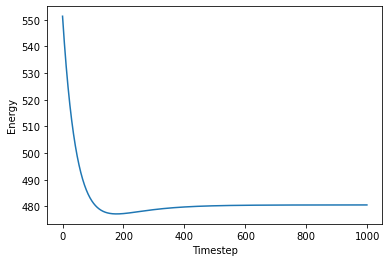

In [18]:
plt.plot(energy_plot)
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.savefig('energy.svg')
plt.show()

In [233]:
###
### Mini MNIST
###

In [234]:
#One-hot encoding
def create_target(t):
        target_vector = np.zeros(10)
        for i in range(10):
            if i == t:
                target_vector[i] = 1
        return target_vector

#Hard sigmoid [-1, 1]
def hsig(x):
    z = np.clip(x, -1, 1)
    return np.copy(z)

def d_hsig(x):
    z = (x > -1) & (x < 1)
    return np.copy(z)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [235]:
#Load mini MNIST data
digits = datasets.load_digits()
data = digits.data
targets = digits.target

#Standardize data
inputs = data - np.mean(data)
inputs = inputs/(np.std(data))

In [236]:
print(data.shape)
print(targets.shape)
print(data[0])
print(targets[11])

(1797, 64)
(1797,)
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
1


In [7]:
#Define network hyperparameters
n_x = 64
n_h = 50
n_y = 10

alpha1 = 0.01
alpha2 = 0.005
beta = 1
epsilon = 0.1

epochs = 50

x_plot = []
h_plot = []
y_plot = []
w1_plot = []
w2_plot = []
energy_plot = []
first_term_plot = []
second_term_plot = []
third_term_plot = []

#Weight intialization
W1 = np.random.uniform(0, (4/(n_x + n_y)), (n_x, n_h))
W2 = np.random.uniform(0, (4/(n_h)), (n_h, n_y))

#Bias initialization
bh = np.random.uniform(0, 4/(n_x + n_y), n_h)
by = np.random.uniform(0, 4/(n_h), n_y)

for ex in range(epochs*100):
    
    #Randomly sample from data
    rnd = np.random.randint(0, 1497)
    x = inputs[rnd]# + 0.1 * np.random.rand(64)
    t = create_target(targets[rnd])
    
    #Random activation initialization
    h = np.random.uniform(-1, 1, n_h)
    y = np.random.uniform(-1, 1, n_y)
    
    #Free Phase
    for itr in range(100):
        #Calculate free gradient steps
        dh = d_hsig(h) * (np.dot(x, W1) + np.dot(y, W2.T) + bh) - h
        dy = d_hsig(y) * (np.dot(h, W2) + by) - y
        
        #Update activations
        h = hsig(h + epsilon * dh)
        y = hsig(y + epsilon * dy)
        
    #Store free equilibrium states
    h_free = np.copy(h)
    y_free = np.copy(y)
    
    #Weakly Clamped Phase
    for itr in range(20):
        #Calculate weakly clamped gradient steps
        dy = d_hsig(y) * (np.dot(h, W2) + by) - y + beta * (t - y)
        dh = d_hsig(h) * (np.dot(x, W1) + np.dot(y, W2.T) + bh) - h
        
        #Update activations
        h = hsig(h + epsilon * dh)
        y = hsig(y + epsilon * dy)
        
    #Store weakly clamped activations
    h_clamped = np.copy(h)
    y_clamped = np.copy(y)
    
    x_plot.append(np.mean(x))
    h_plot.append(np.mean(h))
    y_plot.append(np.mean(y))
    
    #Update weights
    W1 += alpha1 * (1/beta) * (np.outer(x, h_clamped) - np.outer(x, h_free))
    W2 += alpha2 * (1/beta) * (np.outer(h_clamped, y_clamped) - np.outer(h_free, y_free))
    
    w1_plot.append(np.sum(W1))
    w2_plot.append(np.sum(W2))
    
    #Print Mean Squared Error
    if ex % 100 == 0:
        print(np.dot(t - y_free, t - y_free))
        
        energy = epsilon * 0.5 * (np.sum(x**2) + np.sum(h**2) + np.sum(y**2))
        
        w1_mat = W1 * np.outer(hsig(x),hsig(h))
        np.fill_diagonal(w1_mat,0)
        energy -= 0.5 * np.sum(w1_mat)
        
        w2_mat = W2 * np.outer(hsig(h),hsig(y))
        np.fill_diagonal(w2_mat,0)
        energy -= 0.5 * np.sum(w2_mat)

        energy -= 0.5 * np.sum(bh * hsig(h))
        energy -= 0.5 * np.sum(by * hsig(y))
        energy += np.sum((t - y_free)**2)
        energy_plot.append(energy)
        
    #Learning rate schedule
    if ex % 2500 == 2499:
        alpha1 /= 10
        alpha2 /= 10

ValueError: shapes (28,28) and (64,50) not aligned: 28 (dim 1) != 64 (dim 0)

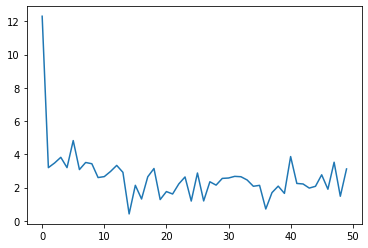

In [238]:
plt.plot(energy_plot)
plt.show()

In [241]:
#Test Accuracy
score = 0
samples = 300
for test in range(samples):
    energy_plot = []
    rnd = np.random.randint(1497, 1797)
    rnd = test + 1497
    x = inputs[rnd]
    t = create_target(targets[rnd])
    h = np.random.uniform(-1, 1, n_h)
    y = np.random.uniform(-1, 1, n_y)
    
    #energy = 0.5 * (np.sum(x**2) + np.sum(h**2) + np.sum(y**2))
    
    #Free Phase
    for itr in range(100):
        dh = d_hsig(h) * (np.dot(x, W1) + np.dot(y, W2.T) + bh) - h
        dy = d_hsig(y) * (np.dot(h, W2) + by) - y
        
        h = hsig(h + epsilon * dh)
        y = hsig(y + epsilon * dy)
        
        energy = 0.5 * (np.sum(x**2) + np.sum(h**2) + np.sum(y**2))
        
        w1_mat = W1 * np.outer(hsig(x),hsig(h))
        np.fill_diagonal(w1_mat,0)
        energy -= 0.5 * np.sum(w1_mat)
        
        w2_mat = W2 * np.outer(hsig(h),hsig(y))
        np.fill_diagonal(w2_mat,0)
        energy -= 0.5 * np.sum(w2_mat)

        energy -= 0.5 * np.sum(bh * hsig(h))
        energy -= 0.5 * np.sum(by * hsig(y))
        energy += np.sum((t - y_free)**2)
        energy_plot.append(energy)
        
    h_free = np.copy(h)
    y_free = np.copy(y)
    
    if np.argmax(y_free) == targets[rnd]:
        score += 1
    
    print('tested sample ' + str(test+1) + ' of '+str(samples), end = "\r")

print('\n')
print(score/samples)

tested sample 300 of 300

0.87


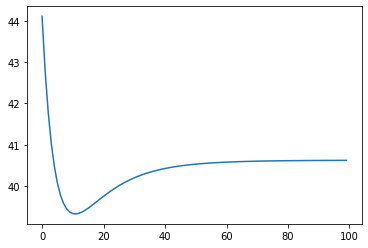

In [242]:
plt.plot(energy_plot)
plt.show()

In [24]:
print(W1)
print(W1.shape)

[[ 2.12778461e-02 -7.96877415e-03  2.55634200e-02 ...  1.43979904e-02
   4.48452780e-02  2.99460474e-02]
 [ 1.28457663e-03  4.08286115e-02  1.68978761e-02 ...  1.25543463e-02
   4.20629966e-02 -7.49259844e-03]
 [ 1.07820521e-02  3.29156993e-02  3.21084334e-02 ...  1.53257483e-02
  -3.37177264e-04  2.65173769e-02]
 ...
 [ 7.89182584e-03  6.56884724e-04  7.74170481e-02 ... -6.99130846e-05
   3.47362730e-02 -1.89836708e-02]
 [ 2.88802880e-03  1.37388219e-02  6.51104752e-02 ... -6.50030592e-03
   5.28052016e-02  2.50678741e-03]
 [ 3.33202712e-02 -9.30478779e-03  1.47214853e-02 ...  5.60654076e-03
   1.39632788e-02  1.62804513e-02]]
(64, 50)


In [19]:
print(np.max(W1))

0.138310378194868


In [20]:
print(np.min(W1))

-0.06975242151465096


In [25]:
print(W2)
print(W2.shape)

[[-4.49563915e-02  3.46079886e-02 -1.58287574e-02  6.56887338e-02
   1.71613387e-02  1.16051095e-02 -4.89696705e-02 -1.29790210e-02
   2.55555570e-02 -4.63367443e-02]
 [ 3.80134948e-02 -1.14539817e-01 -2.94069451e-02 -4.99862516e-03
  -5.62762285e-05 -2.53214435e-02  1.83323301e-02  6.87303098e-02
   1.45935154e-02  2.62324669e-02]
 [-1.69414688e-03  3.81477577e-02  9.45353929e-02  2.08373750e-02
   7.38676376e-02 -5.11676864e-02  4.03174072e-02 -5.67659985e-02
  -1.51900741e-02  3.00757747e-02]
 [-9.86764911e-03  8.91168118e-03  3.16358076e-02 -1.73876369e-02
   2.84838538e-02 -8.46844364e-02 -2.09619955e-02 -5.97433321e-02
   1.71343570e-02 -1.33609716e-02]
 [ 7.48426667e-02 -6.95796407e-03 -4.72176025e-02 -5.16048609e-02
  -3.71490767e-02  5.61286450e-02  6.79278455e-02 -1.59360776e-02
   4.37625924e-02 -4.39607543e-03]
 [ 4.22402516e-02 -3.22041127e-03  2.50110195e-02 -6.58550173e-03
   8.30351163e-03  3.39553137e-03 -1.03002488e-01  7.87346743e-03
   8.83696999e-02 -4.90633035e-02

In [22]:
print(np.max(W2))

0.1328628719874892


In [23]:
print(np.min(W2))

-0.11453981708799395


In [28]:
print(bh.shape)
print(np.max(bh))
print(np.min(bh))

(50,)
0.053006101105460106
0.0022467346772342502


In [29]:
print(by.shape)
print(np.max(by))
print(np.min(by))

(10,)
0.07605909151318212
0.014803063579171525


In [22]:
###
### Initialized Equilibrium Propagation Training
###

In [23]:
#One-hot encoding
def create_target(t):
        target_vector = np.zeros(10)
        for i in range(10):
            if i == t:
                target_vector[i] = 1
        return target_vector

#Hard sigmoid [-1, 1]
def hsig(x):
    z = np.clip(x, -1, 1)
    return np.copy(z)

def d_hsig(x):
    z = (x > -1) & (x < 1)
    return np.copy(z)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [24]:
#Load mini MNIST data
digits = datasets.load_digits()
data = digits.data
targets = digits.target

#Standardize data
inputs = data - np.mean(data)
inputs = inputs/(np.std(data))

In [28]:
#Define network hyperparameters
n_x = 64
n_h = 50
n_y = 10

alpha1 = 0.01
alpha2 = 0.005
beta = 1
epsilon = 0.1

epochs = 50

x_plot = []
h_plot = []
y_plot = []
w1_plot = []
w2_plot = []
energy_plot = []
first_term_plot = []
second_term_plot = []
third_term_plot = []

#Weight intialization
#W1 = np.random.uniform(0, (4/(n_x + n_y)), (n_x, n_h))
#W2 = np.random.uniform(0, (4/(n_h)), (n_h, n_y))

#Bias initialization
#bh = np.random.uniform(0, 4/(n_x + n_y), n_h)
#by = np.random.uniform(0, 4/(n_h), n_y)

W1 = np.load('w1.npy')/10
W2 = np.load('w2.npy')/10
bh = np.load('bh.npy')
by = np.load('by.npy')

#W1 = W1/(250*np.max(W1))
#W2 = W2/(250*np.max(W2))
#bh = bh/(250*np.max(bh))
#by = by/(250*np.max(by))

for ex in range(epochs*100):
    
    #Randomly sample from data
    rnd = np.random.randint(0, 1497)
    x = inputs[rnd]# + 0.1 * np.random.rand(64)
    t = create_target(targets[rnd])
    
    #Random activation initialization
    h = np.random.uniform(-1, 1, n_h)
    y = np.random.uniform(-1, 1, n_y)
    
    #Free Phase
    for itr in range(100):
        #Calculate free gradient steps
        dh = d_hsig(h) * (np.dot(x, W1) + np.dot(y, W2.T) + bh) - h
        dy = d_hsig(y) * (np.dot(h, W2) + by) - y
        
        #Update activations
        h = hsig(h + epsilon * dh)
        y = hsig(y + epsilon * dy)
        
    #Store free equilibrium states
    h_free = np.copy(h)
    y_free = np.copy(y)
    
    #Weakly Clamped Phase
    for itr in range(20):
        #Calculate weakly clamped gradient steps
        dy = d_hsig(y) * (np.dot(h, W2) + by) - y + beta * (t - y)
        dh = d_hsig(h) * (np.dot(x, W1) + np.dot(y, W2.T) + bh) - h
        
        #Update activations
        h = hsig(h + epsilon * dh)
        y = hsig(y + epsilon * dy)
        
    #Store weakly clamped activations
    h_clamped = np.copy(h)
    y_clamped = np.copy(y)
    
    x_plot.append(np.mean(x))
    h_plot.append(np.mean(h))
    y_plot.append(np.mean(y))
    
    #Update weights
    W1 += alpha1 * (1/beta) * (np.outer(x, h_clamped) - np.outer(x, h_free))
    W2 += alpha2 * (1/beta) * (np.outer(h_clamped, y_clamped) - np.outer(h_free, y_free))
    
    w1_plot.append(np.sum(W1))
    w2_plot.append(np.sum(W2))
    
    #Print Mean Squared Error
    if ex % 100 == 0:
        print(np.dot(t - y_free, t - y_free))
        
        energy = epsilon * 0.5 * (np.sum(x**2) + np.sum(h**2) + np.sum(y**2))
        
        w1_mat = W1 * np.outer(hsig(x),hsig(h))
        np.fill_diagonal(w1_mat,0)
        energy -= 0.5 * np.sum(w1_mat)
        
        w2_mat = W2 * np.outer(hsig(h),hsig(y))
        np.fill_diagonal(w2_mat,0)
        energy -= 0.5 * np.sum(w2_mat)

        energy -= 0.5 * np.sum(bh * hsig(h))
        energy -= 0.5 * np.sum(by * hsig(y))
        energy += np.sum((t - y_free)**2)
        energy_plot.append(energy)
        
    #Learning rate schedule
    if ex % 2500 == 2499:
        alpha1 /= 10
        alpha2 /= 10

11.839016572420196
1.4425074114205108
0.7646547336423722
0.7159604486058707
0.3235065516315935
0.5640865389161778
0.480038642528464
0.43037020968875445
0.2781046014783083
0.17401820172990254
0.5103538035057538
0.1343947660401369
0.22376643358811565
0.23039483190418134
0.4533953807977342
0.11758882657978
0.22414540589515763
0.0986077935893622
0.14669706355806084
0.4157534604136547
0.2632070780579873
0.11920977003787715
0.10108868474128871
0.35960879383338845
0.1520616206900028
0.2533410712653201
0.04957686159957233
0.3381873511633017
0.11925703235030581
0.2830992596485435
0.9272507409104406
0.1614375741431236
0.26163262069671545
0.06645554343962795
0.015504588985848054
0.4540882994906393
0.9595722612810677
0.23887991334014538
0.1339376541976654
0.07653291514698461
0.10582812617948581
0.5185766890669639
0.2654602236710985
0.09703851230332095
0.39632400423231046
0.056534921997456425
0.5170865535349647
0.17731114823378843
0.17252919670262687
0.055788909889932375


In [29]:
#Test Accuracy
score = 0
samples = 300
for test in range(samples):
    energy_plot = []
    h_plot = []
    y_plot = []
    rnd = np.random.randint(1497, 1797)
    rnd = test + 1497
    x = inputs[rnd]
    t = create_target(targets[rnd])
    h = np.random.uniform(-1, 1, n_h)
    y = np.random.uniform(-1, 1, n_y)
    
    #energy = 0.5 * (np.sum(x**2) + np.sum(h**2) + np.sum(y**2))
    
    #Free Phase
    for itr in range(100):
        dh = d_hsig(h) * (np.dot(x, W1) + np.dot(y, W2.T) + bh) - h
        dy = d_hsig(y) * (np.dot(h, W2) + by) - y
        
        h = hsig(h + epsilon * dh)
        y = hsig(y + epsilon * dy)
        
        energy = 0.5 * (np.sum(x**2) + np.sum(h**2) + np.sum(y**2))
        
        w1_mat = W1 * np.outer(hsig(x),hsig(h))
        np.fill_diagonal(w1_mat,0)
        energy -= 0.5 * np.sum(w1_mat)
        
        w2_mat = W2 * np.outer(hsig(h),hsig(y))
        np.fill_diagonal(w2_mat,0)
        energy -= 0.5 * np.sum(w2_mat)

        energy -= 0.5 * np.sum(bh * hsig(h))
        energy -= 0.5 * np.sum(by * hsig(y))
        energy += np.sum((t - y_free)**2)
        energy_plot.append(energy)
        h_plot.append(np.mean(h))
        y_plot.append(np.mean(y))
        
    h_free = np.copy(h)
    y_free = np.copy(y)
    
    if np.argmax(y_free) == targets[rnd]:
        score += 1
    
    print('tested sample ' + str(test+1) + ' of '+str(samples), end = "\r")

print('\n')
print(score/samples)

tested sample 300 of 300

0.91


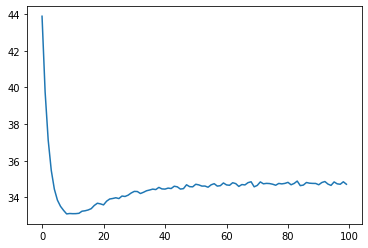

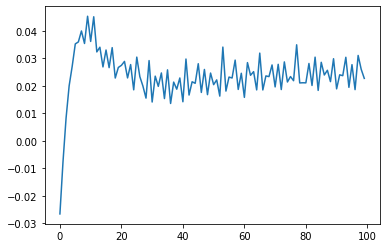

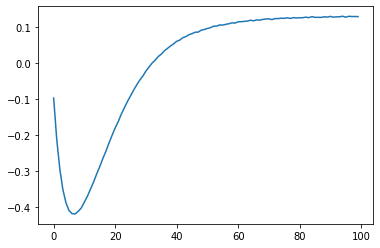

In [30]:
plt.plot(energy_plot)
plt.show()
plt.plot(h_plot)
plt.show()
plt.plot(y_plot)
plt.show()

In [2]:
###
### Weight Transfer
###

In [7]:
#One-hot encoding
def create_target(t):
        target_vector = np.zeros(10)
        for i in range(10):
            if i == t:
                target_vector[i] = 1
        return target_vector

#Hard sigmoid [-1, 1]
def hsig(x):
    z = np.clip(x, -1, 1)
    return np.copy(z)

def d_hsig(x):
    z = (x > -1) & (x < 1)
    return np.copy(z)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [8]:
#Load mini MNIST data
digits = datasets.load_digits()
data = digits.data
targets = digits.target

#Standardize data
inputs = data - np.mean(data)
inputs = inputs/(np.std(data))

In [9]:
W1 = np.load('w1.npy')
W2 = np.load('w2.npy')
bh = np.load('bh.npy')
by = np.load('by.npy')

#W1 = W1/(250*np.max(W1))
#W2 = W2/(250*np.max(W2))
#bh = bh/(250*np.max(bh))
#by = by/(250*np.max(by))
#bh = bh * 0
#by = by * 0

In [10]:
print(np.max(W1))
print(np.max(W2))
print(np.max(bh))
print(np.max(by))

1.7599714
1.9858465
0.33604896
-0.89557695


In [15]:
#Define network hyperparameters
n_x = 64
n_h = 50
n_y = 10

alpha1 = 0.01
alpha2 = 0.005
beta = 1
epsilon = 0.1

epochs = 0.1

x_plot = []
h_plot = []
y_plot = []
w1_plot = []
w2_plot = []
energy_plot = []
first_term_plot = []
second_term_plot = []
third_term_plot = []

#Weight intialization
#W1 = np.random.uniform(0, (4/(n_x + n_y)), (n_x, n_h))
#W2 = np.random.uniform(0, (4/(n_h)), (n_h, n_y))

#Bias initialization
#bh = np.random.uniform(0, 4/(n_x + n_y), n_h)
#by = np.random.uniform(0, 4/(n_h), n_y)

#W1 = np.load('w1.npy')
#W2 = np.load('w2.npy')
#bh = np.load('bh.npy')
#by = np.load('by.npy')

#W1 = W1/(250*np.max(W1))
#W2 = W2/(250*np.max(W2))
#bh = bh/(250*np.max(bh))
#by = by/(250*np.max(by))

for ex in range(int(epochs*100)):
    
    #Randomly sample from data
    rnd = np.random.randint(0, 1497)
    x = inputs[rnd]# + 0.1 * np.random.rand(64)
    t = create_target(targets[rnd])
    
    #Random activation initialization
    h = np.random.uniform(-1, 1, n_h)
    y = np.random.uniform(-1, 1, n_y)
    
    #Free Phase
    for itr in range(100):
        #Calculate free gradient steps
        dh = d_hsig(h) * (np.dot(x, W1) + np.dot(y, W2.T) + bh) - h
        dy = d_hsig(y) * (np.dot(h, W2) + by) - y
        
        #Update activations
        h = hsig(h + epsilon * dh)
        y = hsig(y + epsilon * dy)
        
    #Store free equilibrium states
    h_free = np.copy(h)
    y_free = np.copy(y)
    
    #Weakly Clamped Phase
    for itr in range(20):
        #Calculate weakly clamped gradient steps
        dy = d_hsig(y) * (np.dot(h, W2) + by) - y + beta * (t - y)
        dh = d_hsig(h) * (np.dot(x, W1) + np.dot(y, W2.T) + bh) - h
        
        #Update activations
        h = hsig(h + epsilon * dh)
        y = hsig(y + epsilon * dy)
        
    #Store weakly clamped activations
    h_clamped = np.copy(h)
    y_clamped = np.copy(y)
    
    x_plot.append(np.mean(x))
    h_plot.append(np.mean(h))
    y_plot.append(np.mean(y))
    
    #Update weights
    W1 += alpha1 * (1/beta) * (np.outer(x, h_clamped) - np.outer(x, h_free))
    W2 += alpha2 * (1/beta) * (np.outer(h_clamped, y_clamped) - np.outer(h_free, y_free))
    
    w1_plot.append(np.sum(W1))
    w2_plot.append(np.sum(W2))
    
    #Print Mean Squared Error
    if ex % 100 == 0:
        print(np.dot(t - y_free, t - y_free))
        
        energy = epsilon * 0.5 * (np.sum(x**2) + np.sum(h**2) + np.sum(y**2))
        
        w1_mat = W1 * np.outer(hsig(x),hsig(h))
        np.fill_diagonal(w1_mat,0)
        energy -= 0.5 * np.sum(w1_mat)
        
        w2_mat = W2 * np.outer(hsig(h),hsig(y))
        np.fill_diagonal(w2_mat,0)
        energy -= 0.5 * np.sum(w2_mat)

        energy -= 0.5 * np.sum(bh * hsig(h))
        energy -= 0.5 * np.sum(by * hsig(y))
        energy += np.sum((t - y_free)**2)
        energy_plot.append(energy)
        
    #Learning rate schedule
    if ex % 2500 == 2499:
        alpha1 /= 10
        alpha2 /= 10

8.620000000000001


In [20]:
#Test Accuracy
score = 0
samples = 300
for test in range(samples):
    energy_plot = []
    h_plot = []
    y_plot = []
    rnd = np.random.randint(1497, 1797)
    rnd = test + 1497
    x = inputs[rnd]
    t = create_target(targets[rnd])
    h = np.random.uniform(-1, 1, n_h)
    y = np.random.uniform(-1, 1, n_y)
    
    #energy = 0.5 * (np.sum(x**2) + np.sum(h**2) + np.sum(y**2))
    
    #Free Phase
    for itr in range(100):
        dh = d_hsig(h) * (np.dot(x, W1) + np.dot(y, W2.T) + bh) - h
        dy = d_hsig(y) * (np.dot(h, W2) + by) - y
        
        h = hsig(h + epsilon * dh)
        y = hsig(y + epsilon * dy)
        
        energy = 0.5 * (np.sum(x**2) + np.sum(h**2) + np.sum(y**2))
        
        w1_mat = W1 * np.outer(hsig(x),hsig(h))
        np.fill_diagonal(w1_mat,0)
        energy -= 0.5 * np.sum(w1_mat)
        
        w2_mat = W2 * np.outer(hsig(h),hsig(y))
        np.fill_diagonal(w2_mat,0)
        energy -= 0.5 * np.sum(w2_mat)

        energy -= 0.5 * np.sum(bh * hsig(h))
        energy -= 0.5 * np.sum(by * hsig(y))
        energy += np.sum((t - y_free)**2)
        energy_plot.append(energy)
        h_plot.append(np.mean(h))
        y_plot.append(np.mean(y))
        
    h_free = np.copy(h)
    y_free = np.copy(y)
    
    if np.argmax(y_free) == targets[rnd]:
        score += 1
    
    print('tested sample ' + str(test+1) + ' of '+str(samples), end = "\r")

print('\n')
print(score/samples)

tested sample 300 of 300

0.9266666666666666


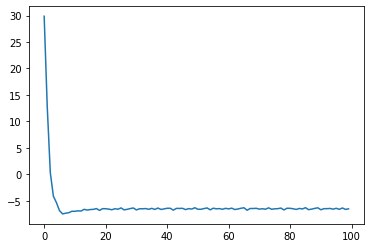

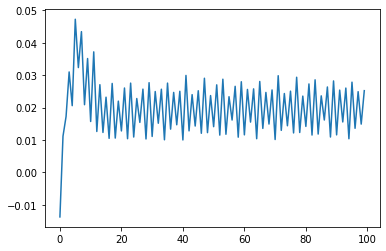

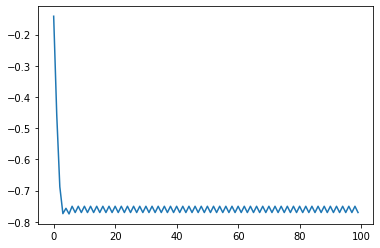

In [21]:
plt.plot(energy_plot)
plt.show()
plt.plot(h_plot)
plt.show()
plt.plot(y_plot)
plt.show()